# SL Models

https://sites.gatech.edu/omscs7641/2024/02/07/introduction-to-classification-model-comparison-methods/

In [ ]:
%pip install -r requirements.txt

In [8]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns
import sklearn.metrics as skm

In [2]:
iris = load_iris()
x = pl.DataFrame(
    iris.data,
    schema=[
        "sepal length (cm)",
        "sepal width (cm)",
        "petal length (cm)",
        "petal width (cm)",
    ],
)
y = iris.target
x.head()

sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
f64,f64,f64,f64
5.1,3.5,1.4,0.2
4.9,3.0,1.4,0.2
4.7,3.2,1.3,0.2
4.6,3.1,1.5,0.2
5.0,3.6,1.4,0.2


In [3]:
# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=35
)

## Build Models

In [4]:
# model1: sepal len and width only
# set up a random classifier and train on the subset of sepal features,
# make predictions on the test set with the sepal features
sepal_features = ["sepal length (cm)", "sepal width (cm)"]
model_one = RandomForestClassifier(random_state=35)
model_one.fit(x_train[sepal_features], y_train)
model_one_pred = model_one.predict(x_test[sepal_features])

In [5]:
# model2: all features
# set up a random classifier and train on all features
# make predictions on the test set with all features
model_two = RandomForestClassifier(random_state=35)
model_two.fit(x_train, y_train)
model_two_pred = model_two.predict(x_test)

## Eval Performance Metrics

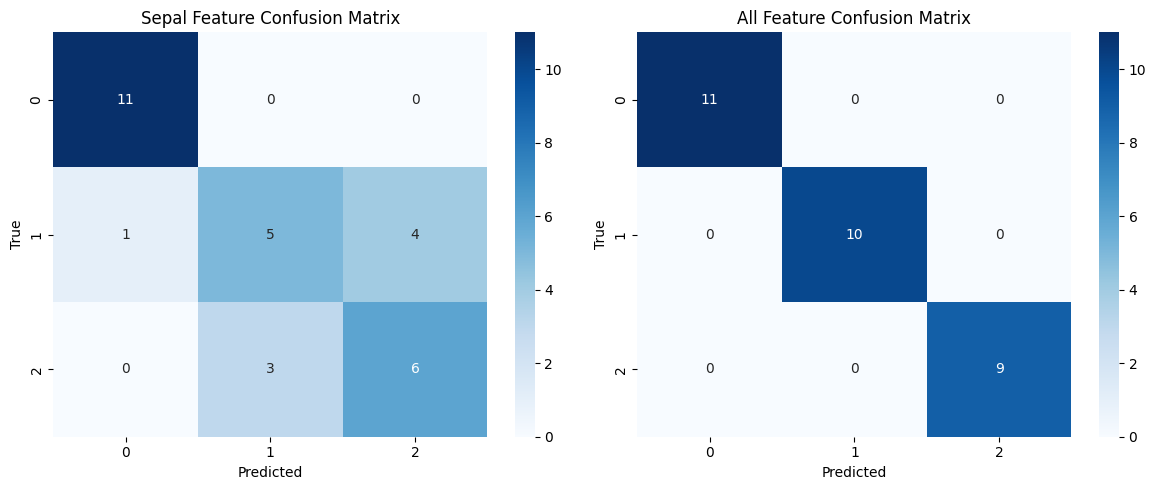

In [7]:
# Create confusion matrices for each model and then plot as a heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

cm1 = confusion_matrix(y_test, model_one_pred)
cm2 = confusion_matrix(y_test, model_two_pred)

sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", ax=ax1).set(
    title="Sepal Feature Confusion Matrix", xlabel="Predicted", ylabel="True"
)
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", ax=ax2).set(
    title="All Feature Confusion Matrix", xlabel="Predicted", ylabel="True"
)
plt.tight_layout()
plt.show()

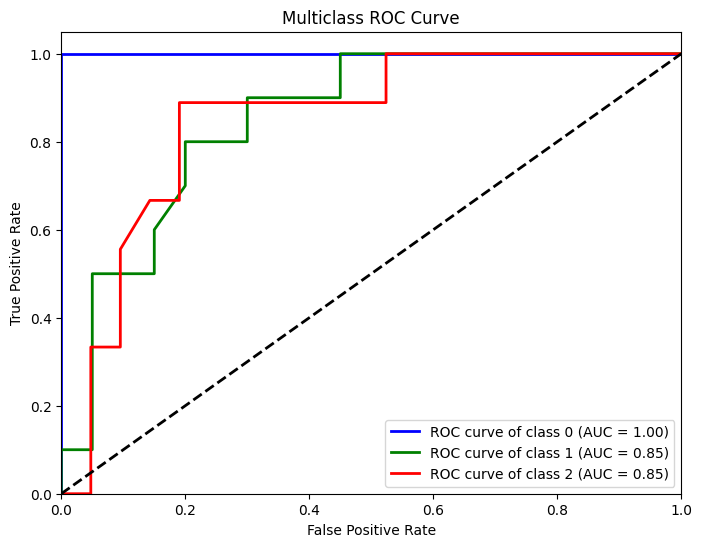

In [11]:
# you can also use ROC curves to evaluate the performance of a classifier

# Train a classifier
classifier = OneVsRestClassifier(RandomForestClassifier(random_state=35))
classifier.fit(x_train[sepal_features], y_train)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
probs = classifier.predict_proba(x_test[sepal_features])
for i in range(3):
    prob = [x[i] for x in probs]
    actuals = [1 if x == i else 0 for x in y_test]
    fpr[i], tpr[i], _ = skm.roc_curve(actuals, prob)
    roc_auc[i] = skm.auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = ["blue", "green", "red"]
for i, color in zip(range(3), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="ROC curve of class {0} (AUC = {1:0.2f})" "".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.show()

## Interpret 

representation of the contribution of each feature to the difference between the actual and average prediction

In [ ]:
# Tree SHAP algorithms explain the output of ensemble tree models

# Create shap plots for each model
x_test = x_test.to_pandas()  # no shap
explainer_one = shap.TreeExplainer(model_one)
shap_values_one = explainer_one.shap_values(x_test[sepal_features])

explainer_two = shap.TreeExplainer(model_two)
shap_values_two = explainer_two.shap_values(x_test)

fig, ax = plt.subplots(figsize=(15, 5))
shap.summary_plot(shap_values_one, x_test[sepal_features], plot_type="bar")

fig, ax = plt.subplots(figsize=(15, 5))
shap.summary_plot(shap_values_two, x_test, plot_type="bar")

In [ ]:
# partial dependence plots (show how features impact model determinations)